## Download a youtube video

In [1]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00


In [2]:
from pytube import YouTube

In [3]:
def Download(link):
    youtubeObject = YouTube(link)
    youtubeObject = youtubeObject.streams.get_highest_resolution()
    try:
        youtubeObject.download(output_path="")
    except:
        print("An error has occurred")
    print("Download is completed successfully")

In [4]:
link = "https://www.youtube.com/watch?v=NsRLOV4pHyk&t=6s"
# Download(link)

## Object detection

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.9 MB/s eta 0:00:00


In [6]:
import cv2
import numpy as np
import torch.cuda
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches
from tqdm.notebook import tqdm
import threading
import time

from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
from itertools import product

In [7]:
def frame_to_tensor(frame: np.ndarray):
    transform = transforms.ToTensor()
    frame_t = transform(frame)
    return frame_t

In [8]:
def get_frame_patches(frame: np.ndarray, patch_size):
    """
    Function to split the frame into patches of size @patch_dim
    :param frame: the frame of the video
    :param patch_size: the dimension of the patches
    :return: the patches
    """
    frame_t = frame_to_tensor(frame)
    # unfold the tensor along the 0-dimension to get the batch dimension
    patches = frame_t.data.unfold(0, 3, 3)

    # create vertical patches (in the height dimension)
    patches = patches.unfold(1, patch_size, patch_size)

    # create horizontal patches (in width dimension)
    patches = patches.unfold(2, patch_size, patch_size)

    print(f"Shape of the patches = {patches.shape}")
    return patches

In [9]:
def load_model(model_id="openai/clip-vit-base-patch32"):
    """
    Function to load the transformer model and the respective preprocessor
    :param model_id: id of the model to load
    :return: the processor and the model requested
    """
    processor = CLIPProcessor.from_pretrained(model_id)
    model = CLIPModel.from_pretrained(model_id)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    return model, processor, device

In [10]:
def run_inference(model, processor, device, prompt, patches, patch_size, window, stride):
    """
    Function to run the model and get the similarity scores
    :param model: the Visual Transformer to be run
    :param processor: the processor associated to the Transformer to run
    :param device: the hardware devoted to run the model
    :param patches: the patches drawn from the frame
    :param patch_size: the size of the patches
    :param window: the amount of patches seen by the model
    :return: scores associated to the big patches
    """
    scores = torch.zeros(patches.shape[1], patches.shape[2])
    runs = torch.ones(patches.shape[1], patches.shape[2])

    for Y in range(0, patches.shape[1]-window+1, stride):
        for X in range(0, patches.shape[2]-window+1, stride):
            big_patch = torch.zeros(patch_size * window, patch_size * window, 3)
            patch_batch = patches[0, Y:Y+window, X:X+window]
            for y in range(window):
                for x in range(window):
                    big_patch[
                    y * patch_size:(y + 1) * patch_size, x * patch_size:(x + 1) * patch_size, :
                    ] = patch_batch[y, x].permute(1, 2, 0)
            # we preprocess the image and class label with the CLIP processor
            inputs = processor(
                images=big_patch,  # big patch image sent to CLIP
                return_tensors="pt",  # tell CLIP to return pytorch tensor
                text=prompt,  # class label sent to CLIP
                padding=True
            ).to(device) # move to device if possible

            # calculate and retrieve similarity score
            score = model(**inputs).logits_per_image.item()
            # sum up similarity scores from current and previous big patches
            # that were calculated for patches within the current window
            scores[Y:Y+window, X:X+window] += score
            # calculate the number of runs on each patch within the current window
            runs[Y:Y+window, X:X+window] += 1
    # calculate average scores
    scores /= runs
    # clip scores
    for _ in range(3):
        scores = np.clip(scores-scores.mean(), 0, np.inf)
    # normalize scores
    scores = (scores - scores.min()) / (scores.max() - scores.min())
    #scores = (scores - scores.mean()) / scores.std()
    #print(f'The max score is {scores.max()}, while the min score is {scores.min()}')
    return scores

In [11]:
def get_box(scores, patch_size, threshold):
    detection = scores > threshold
    # find box corners
    y_min, y_max = np.nonzero(detection)[:, 0].min().item(), np.nonzero(detection)[:, 0].max().item()+1
    x_min, x_max = np.nonzero(detection)[:, 1].min().item(), np.nonzero(detection)[:, 1].max().item()+1
    print(f'The x_min is {x_min} and x_max is {x_max} and their scores are {(np.nonzero(detection)[:, 1].min()), np.nonzero(detection)[:, 1].max()}')
    print(f'The detection for the y is {np.nonzero(detection)[:, 0]}')
    print(f'The detection for the x is {np.nonzero(detection)[:, 1]}')
    # convert from patch co-ords to pixel co-ords
    y_min *= patch_size
    y_max *= patch_size
    x_min *= patch_size
    x_max *= patch_size
    # calculate box height and width
    height = y_max - y_min
    width = x_max - x_min
    return x_min, y_min, width, height

In [12]:
def get_multi_box(scores, patch_size, threshold):

    # Convert the scores to a numpy array if it's a tensor
    if torch.is_tensor(input):
      scores = scores.numpy()
    # print(f"The scores' shape si {scores.shape}")

    # Print the scores as an image to see the locations
    '''
    print(f'Printing the scores matrix')
    row_string = ''
    for row in scores:
      for col in row:
        row_string += '{:2f} '.format(col)
      row_string += '\n'
    print(row_string)
    '''

    # Define the matrix with only the good scores
    detection = np.zeros((scores.shape))

    # Consider only the region of interest in the image
    detection[scores > threshold] = scores[scores > threshold]
    # detection = np.nonzero(detection)
    print(f'The shape of the detection is {detection.shape}')

    # Print the scores as an image to see the locations
    '''
    print(f'Printing the detection matrix')
    row_string = ''
    for row in detection:
      for col in row:
        row_string += '{:2f} '.format(col)
      row_string += '\n'
    print(row_string)
    '''

    bb_dict = {}
    finished = False
    bb_finished = False
    bb_idx = 0
    x_coo = 0
    y_coo = 0
    elem_to_check = []
    num_cells_different_from_zero = 0

    while not finished:
      # Init the dictionary
      bb_dict[bb_idx] = {}
      bb_dict[bb_idx]['x'] = []
      bb_dict[bb_idx]['y'] = []
      # Add the current element to the check list
      elem_to_check.append((x_coo, y_coo))
      # Till there are elements to check
      while len(elem_to_check) > 0:
        current_position = elem_to_check.pop(0)
        # If the current location is different from zero
        # print(f'Current cells is {current_position}')
        if detection[current_position[0], current_position[1]] != 0:
          num_cells_different_from_zero += 1
          # Add the current elem to the dict
          bb_dict[bb_idx]['x'].append(current_position[0])
          bb_dict[bb_idx]['y'].append(current_position[1])
          # Set to zero the location already added
          detection[current_position[0], current_position[1]] = 0
          # Check the 4 cells around if they are still valid cells
          if current_position[1]+1 < detection.shape[1]:
            elem_to_check.append((current_position[0], current_position[1]+1))
          if current_position[0]+1 < detection.shape[0]:
            elem_to_check.append((current_position[0]+1, current_position[1]))
          if current_position[0]-1 >= 0:
            elem_to_check.append((current_position[0]-1, current_position[1]))
          if current_position[1]-1 >= 0:
            elem_to_check.append((current_position[0], current_position[1]-1))
            
      # Go to the next bb
      bb_idx += 1
      # Update x_coo and y_coo
      if x_coo < detection.shape[0] - 1:
        x_coo += 1
      elif y_coo < detection.shape[1] - 1:
        x_coo = 0
        y_coo += 1
      else: 
        # If in the last position
        finished = True
    print(f'Finished the computation of the bounding boxes')

    final_list_of_bb = []
    for key, item in bb_dict.items():
      x_values = item['x']
      y_values = item['y']

      if len(x_values) > 0 and len(y_values) > 0:

        '''
        print(f'The points in the bounding box {key} are: ')
        print(f'x: {x_values}')
        print(f'y: {y_values}')
        '''

        # find box corners
        y_min, y_max = min(y_values), max(y_values)+1
        x_min, x_max = min(x_values), max(x_values)+1

        # convert from patch co-ords to pixel co-ords
        y_min *= patch_size
        y_max *= patch_size
        x_min *= patch_size
        x_max *= patch_size

        # calculate box height and width
        width = y_max - y_min
        height = x_max - x_min

        # Append the bb
        final_list_of_bb.append((y_min, x_min, width, height))

    # Return the whole list
    print(f'The number of boxes detected is {len(final_list_of_bb)}')
    print(f'The number of cells different from zero is {num_cells_different_from_zero}')
    return final_list_of_bb

In [13]:
def detect(model, processor, device, prompts, frame, patch_size=64, window=3, stride=1, threshold=0.5, single_box=True):
    """
    Function to the detect the objects in the frame. It uses the frames to look for the specified items.
    It creates a plot of the image containing the detected objects.
    :param model: model to run for the inference
    :param processor: processor associated to the model
    :param device: the hardware used to run the inference
    :param prompts: the objects to find in the frame
    :param frame: the specified frame
    :param patch_size: the size of the patches
    :param window: the amount of patches to search in simultaneously
    :return: the bounding box parameters
    """
    colors = ['#FAFF00', '#8CF1FF']
    # build image patches for detection
    frame_patches = get_frame_patches(frame, patch_size)
    frame_t = frame_to_tensor(frame)
    # convert image to format for displaying with matplotlib
    """
    image = np.moveaxis(frame_t.data.numpy(), 0, -1)
    X = frame_patches.shape[1]
    Y = frame_patches.shape[2]
    # initialize plot to display image + bounding boxes
    fig, ax = plt.subplots(figsize=(Y*0.5, X*0.5))
    ax.imshow(image)
    """
    bounding_box_list = []
    # process image through object detection steps
    for i, prompt in enumerate(tqdm(prompts)):
        scores = run_inference(model, processor, device, prompt, frame_patches, patch_size, window, stride)
        if single_box:
          x, y, width, height = get_box(scores, patch_size, threshold)
          if width > 0 and height > 0:
            bounding_box_list.append((x, y, width, height))
        else: # If multi box
          bb_list = get_multi_box(scores, patch_size, threshold)
          for bb in bb_list:
            bounding_box_list.append(bb)
        # create the bounding box
        # rect = pltpatches.Rectangle((x, y), width, height, linewidth=3, edgecolor=colors[i], facecolor='none')
        # cv2.rectangle(frame, (x, y), (x+width, y+height), [0, 255, 0])
        # add the patch to the Axes
        # ax.add_patch(rect)
    # cv2.imshow("Frame", frame)
    return bounding_box_list

## Online Object Detection

In [14]:
def show_video_and_detect(input_file_path, prompts):
    """
    Function to show the video in an external window.
    When the video is paused the detection algorithm is run with the specified prompts.
    @param: input_file_path path of the video to be shown
    """
    # Show the video
    capture = cv2.VideoCapture(input_file_path)
    frame_width = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
    frame_height = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = np.ceil(capture.get(cv2.CAP_PROP_FPS))
    print(f"fps:{fps:.2f}, frame width: {frame_width}, frame height: {frame_height}")

    model, processor, device = load_model()

    while capture.isOpened():
        ret, frame = capture.read()

        if ret:
            clear_output(wait=True)
            cv2_imshow(frame)
            # Press Q on keyboard to exit
            key = cv2.waitKey(25)
            if key & 0xFF == ord('q'):
                break
            elif key == 32:
                t0 = time.time()
                detect(model, processor, prompts=prompts, device=device, frame=frame)
                t1 = time.time()
                print(f"Time for detection = {t1-t0}")
                cv2.waitKey()
        # Break the loop
        else:
            break
    # When everything done, release
    # the video capture object
    capture.release()

    # Closes all the frames
    cv2.destroyAllWindows()

In [15]:
# show_video_and_detect("/content/The Devil Wears Prada (45) Movie CLIP - Andy Gets a Makeover (2006) HD.mp4", prompts=["black t-shirt"])

##  Offline object detection


In [16]:
!pip install pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!pip install youtube_dl==2020.12.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.8 MB/s eta 0:00:00


In [18]:
import pafy
import random
import youtube_dl
import cv2 as cv
from tqdm import tqdm

In [19]:
# Get the videon 
ydl_opts = {}
ydl=youtube_dl.YoutubeDL(ydl_opts)
info_dict=ydl.extract_info("https://www.youtube.com/watch?v=HSPYgwP9R84", download=False)
formats = info_dict.get('formats', None)
for f_number, f in enumerate(formats):
  if f.get('format_note', None) == '360p' and f.get('ext', None) == 'mp4' and f.get('filesize', None) != None:
    print(f)

[youtube] HSPYgwP9R84: Downloading webpage
{'format_id': '396', 'url': 'https://rr2---sn-qxo7rn7r.googlevideo.com/videoplayback?expire=1684211374&ei=TrJiZMKXL9Oq6QKhkpjQBg&ip=35.223.191.156&id=o-AGl60OF4E94MtGVZfrgTOF0n41qRxEmWXXWDKDPXLGsb&itag=396&aitags=133%2C134%2C135%2C136%2C137%2C160%2C242%2C243%2C244%2C247%2C248%2C278%2C394%2C395%2C396%2C397%2C398%2C399&source=youtube&requiressl=yes&mh=6q&mm=31%2C26&mn=sn-qxo7rn7r%2Csn-5goeenes&ms=au%2Conr&mv=m&mvi=2&pl=21&vprv=1&svpuc=1&mime=video%2Fmp4&ns=CuHSSbosWBS4UN06LkHxPCgN&gir=yes&clen=3911216&dur=159.534&lmt=1617694467598556&mt=1684189260&fvip=1&keepalive=yes&fexp=24007246&c=WEB&txp=5531432&n=lPrqfrk9ZGgIFhLvOi&sparams=expire%2Cei%2Cip%2Cid%2Caitags%2Csource%2Crequiressl%2Cvprv%2Csvpuc%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&sig=AOq0QJ8wRQIhAIDw7geqDML_C-q8SA-kDY5ismU57yyefKediJEXHNm_AiBMNCpAO1wAo56uGYx2bX4HYBmNnGY8OsNxU2oRAAIpxw%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl&lsig=AG3C_xAwRgIhAK5Q5YhKib0Ddoh-aJR84-0TUHSh_Wn5E1GdUc8_Zj3qA

Code to adjust the frame

In [20]:
def adjust_frame(frame, patch_size):
  def reduce_size_black_rows(frame, patch_size, upper_limit, lower_limit):
    """
    Performs in-place reduction of the size of the black rows
    """
    zeros_row = np.zeros(frame.shape[1:]).astype(int)
    indices = np.array([i for i in range(frame.shape[0]) if (frame[i,:,:] == zeros_row).all()])
    if len(indices) > 0:
      upper_indices = indices[indices <= lower_limit]
      lower_indices = indices[indices >= upper_limit]
      #print(f'The shape of the frame is {frame.shape}')
      #print(f'The shape of upper_indices is {upper_indices.shape}')
      #print(f'The shape of lower_indices is {lower_indices.shape}')
      # a border = patch_size/2 is left at the top and the bottom of the frame
      if upper_indices.shape[0] > 0:
        min_row_idx = max([upper_indices[len(upper_indices)-1] - int(patch_size/2),0])
      else:
        min_row_idx = 0
      if lower_indices.shape[0] > 0:
        max_row_idx = min([lower_indices[0] + int(patch_size/2),frame.shape[0]])
      else:
        max_row_idx = frame.shape[0]
      
      rows_idxs = np.zeros(frame.shape[0]).astype(bool)
      rows_idxs[min_row_idx:max_row_idx+1] = 1

      return frame[rows_idxs,:,:]
    return frame


  def add_black_columns(frame, patch_size):
    """
    Performs in-place black columns concatenation to frame
    """
    n_columns = int(patch_size/2)
    vertical_black_col = np.zeros((frame.shape[0],n_columns,3)).astype(int)
    frame = np.concatenate((frame,vertical_black_col), axis=1)
    frame = np.concatenate((vertical_black_col,frame), axis=1)
    return frame


  #frame = reduce_size_black_rows(frame, patch_size, upper_limit=430, lower_limit=50)
  frame = add_black_columns(frame, patch_size)

  return frame

In [21]:
def detect_objects(video_url, prompts, frame_per_second=5, patch_size=64, window=3, stride=1, threshold=0.5, single_box=True, frames_union=None):
  """
  Function to detect the specified object in each frame of the video
  @param: video_url is the link to the video to analyse
  @param: prompts is a list of texts descriving the objects to detect
  @param: frame_per_second is the number of frame to analyse in a second
  @param: it indicates the number of frames to concatenate in the same image
  @param: the others are related to the object detection
  """
  # Get the video
  ydl_opts = {}
  ydl=youtube_dl.YoutubeDL(ydl_opts)
  info_dict=ydl.extract_info(video_url, download=False)

  # Instanciate the lists
  images_list = []
  filenames_list = []
  bounding_box_list = []

  model, processor, device = load_model()

  formats = info_dict.get('formats', None)
  print("Obtaining frames")
  for f_number, f in enumerate(formats):

    # If the resolution is 360p and if the format is webm (faster than mp4)
    if f.get('format_note', None) == '360p' and f.get('ext', None) == 'webm' and f.get('filesize', None) != None:
      # Get the url
      url = f.get('url', None)

      # Define how many frames to skip between each analysis
      skip_frames = int(f['fps'] / frame_per_second)

      cap = cv.VideoCapture(url)
      current_frame = 0
      t0 = time.time()
      # Till the end of the video
      while True:
        print(f'Computing frame number {len(images_list)}')
        # Get the frame
        ret, frame = cap.read()

        if not ret:
            print(f'Finished the video')
            break

        # Add columns to the frame to improve the quality of the detections
        frame = adjust_frame(frame, patch_size)


        # Define a name for the frame
        filename = r"video_shot" + str(len(images_list)) + ".png"
        # If save the frame
        # cv.imwrite(filename, frame)
        # Append the frame and the filename in the lists
        images_list.append(frame)
        filenames_list.append(filename)
        bounding_boxes = detect(model,
                                processor, 
                                prompts=prompts, 
                                device=device, 
                                frame=frame,
                                patch_size=patch_size, 
                                window=window, 
                                stride=stride, 
                                threshold=threshold,
                                single_box=single_box)
        bounding_box_list.append(bounding_boxes)

        # Skip some frames
        current_frame += skip_frames
        cap.set(1, current_frame)
        if cv.waitKey(30) & 0xFF == ord('q'):
            break
      print("Saved {} images with format {} and resolution {} in {:.4} seconds ({:.4} minutes)".format(len(images_list), f.get('ext', None), f.get('format_note',None), (time.time() - t0), (time.time() - t0) / 60 ))
      # If a valid format has been found and analysed
      # if len(images_list) > 0:
      #  break
      # cap.release()
  # Return the lists
  return  images_list, filenames_list, bounding_box_list

In [22]:
def show_frames(images, row_dim=4, num_of_images=None):
  """
  Function to show all the frames in the list
  @params: images is the list of images
  @params: row_dim is the number of images to show in a row
  @param: num_of_images indicates how many images to show
  """
  if num_of_images == None or num_of_images <= 0 or num_of_images > len(images):
    num_of_images = len(images)

  fig, axs = plt.subplots(int(num_of_images / row_dim) + 1, row_dim, figsize=(20, len(images[0][0]) // row_dim))

  for i in tqdm(range(num_of_images)):
    axs[int(i/row_dim), i%row_dim].imshow(images[i])
    axs[int(i/row_dim), i%row_dim].set_title('Frame: {}'.format(i))

  plt.plot()

In [23]:
def show_frames_with_bounding_box(images_list, bounding_boxes, row_dim=6, num_of_images=None):
  """
  Function to show all the frames in the list with the found bounding box
  @params: images_list is the list of images
  @params: bounding_boxes is a list of bounding box associated with the images.
            For each image there a list of tuple: (x, y, width, heigth)
  @params: row_dim is the number of images to show in a row
  @param: num_of_images indicates how many images to show
  """
  # Create a copy of the list
  images = [image.astype(np.uint8) for image in images_list]

  if num_of_images == None or num_of_images <= 0 or num_of_images > len(images):
    num_of_images = len(images)

  if int(num_of_images / row_dim) == 1:
    fig, axs = plt.subplots(int(num_of_images / row_dim), row_dim, figsize=(20, len(images[0][0]) // row_dim))  
    for i in tqdm(range(num_of_images)):
      # If there is at least one box
      if len(bounding_boxes[i]) > 0:
        # img = np.array(images[i])
        for bb in bounding_boxes[i]:
          images[i] = cv2.rectangle(images[i], # frame
                        (bb[0], # x
                        bb[1]),# y 
                        (bb[0]+bb[2], # width
                        bb[1]+bb[3]),# length 
                        (random.randint(128, 255), random.randint(128, 255), random.randint(128, 255))) # random color
        axs[i%row_dim].imshow(images[i])
        axs[i%row_dim].set_title('Frame: {}'.format(i))

    plt.plot()
    return


  fig, axs = plt.subplots(int(np.ceil(num_of_images / row_dim)), row_dim, figsize=(20, len(images[0][0]) // row_dim))

  for i in tqdm(range(num_of_images)):
    # If there is at least one box
    if len(bounding_boxes[i]) > 0:
      # img = np.array(images[i])
      for bb in bounding_boxes[i]:
        images[i] = cv2.rectangle(images[i], # frame
                      (bb[0], # x
                       bb[1]),# y 
                      (bb[0]+bb[2], # width
                       bb[1]+bb[3]),# length 
                      (random.randint(128, 255), random.randint(128, 255), random.randint(128, 255))) # random color
    axs[int(i/row_dim), i%row_dim].imshow(images[i])
    axs[int(i/row_dim), i%row_dim].set_title('Frame: {}'.format(i))

  plt.plot()

In [24]:
'''images_list, image_names_list, bounding_box_list = detect_objects(
    video_url="https://www.youtube.com/watch?v=HSPYgwP9R84", # The devil wears Prada
    # prompts=["a lamp", "a black jacket"],
    prompts=["a lamp"],
    frame_per_second=0.1, 
    patch_size=18, 
    window=10,
    stride=1, 
    threshold=0.2,
    single_box=False,
    frames_union=4)
  '''

'images_list, image_names_list, bounding_box_list = detect_objects(\n    video_url="https://www.youtube.com/watch?v=HSPYgwP9R84", # The devil wears Prada\n    # prompts=["a lamp", "a black jacket"],\n    prompts=["a lamp"],\n    frame_per_second=0.1, \n    patch_size=18, \n    window=10,\n    stride=1, \n    threshold=0.2,\n    single_box=False,\n    frames_union=4)\n  '

In [25]:
'''images_list, image_names_list, bounding_box_list = detect_objects(
    video_url="https://www.youtube.com/watch?v=NsRLOV4pHyk&t=6s", # iron-man vs Loki
    prompts=["a green t-shirt"],
    frame_per_second=0.1, 
    patch_size=24, 
    window=10,
    stride=1, 
    threshold=0.1,
    single_box=False)
  '''

'images_list, image_names_list, bounding_box_list = detect_objects(\n    video_url="https://www.youtube.com/watch?v=NsRLOV4pHyk&t=6s", # iron-man vs Loki\n    prompts=["a green t-shirt"],\n    frame_per_second=0.1, \n    patch_size=24, \n    window=10,\n    stride=1, \n    threshold=0.1,\n    single_box=False)\n  '

In [26]:
#print(f'The number of frames is {len(images_list)}')

In [27]:
# show_frames(images=images_list, row_dim=8, num_of_images=None)

In [28]:
# show_frames_with_bounding_box(images_list=images_list, bounding_boxes=bounding_box_list, row_dim=2, num_of_images=None)

## Let's try to concatenate frames before the detections to avoid useless bounding boxes

In [29]:
import math

In [30]:
def get_video_frames(video_url, resolution='480p', frame_per_second=5, patch_size=32, concat_x=2, concat_y=2):
  """
  Function to detect the specified object in each frame of the video
  @param: video_url is the link to the video to analyse
  @param: resolution is the resolution of the video to acquire
  @param: frame_per_second is the number of frame to analyse in a second
  @param: concat_x indicates the number of frames to concatenate in a row
  @param: concat_y indicates the number of frames to concatenate in a column
  """
  # Get the video
  ydl_opts = {}
  ydl=youtube_dl.YoutubeDL(ydl_opts)
  info_dict=ydl.extract_info(video_url, download=False)

  # Instanciate the list
  images_list = []

  # Check the resolution
  list_of_available_resolutions = ['240p', '360p', '480p', '720p']
  if resolution not in list_of_available_resolutions:
    resolution = list_of_available_resolutions[0]

  formats = info_dict.get('formats', None)
  print("Obtaining frames")
  for f_number, f in enumerate(formats):

    # If the resolution is 360p and if the format is webm (faster than mp4)
    if f.get('format_note', None) == resolution and f.get('ext', None) == 'webm' and f.get('filesize', None) != None:
      # Get the url
      url = f.get('url', None)

      # Define how many frames to skip between each analysis
      skip_frames = int(f['fps'] / frame_per_second)

      cap = cv.VideoCapture(url)
      current_frame = 0
      t0 = time.time()
      # Till the end of the video
      while True:
        print(f'Computing frame number {len(images_list)}')
        # Get the frame
        ret, frame = cap.read()

        if not ret:
            print(f'Finished the video')
            break

        # Add columns to the frame to improve the quality of the detections
        frame = adjust_frame(frame, patch_size)

        # Save the shape of the frame
        frame_dimension = frame.shape

        # If save the frame
        # cv.imwrite(filename, frame)
        # Append the frame and the filename in the lists
        images_list.append(frame)

        # Skip some frames
        current_frame += skip_frames
        cap.set(1, current_frame)
        if cv.waitKey(30) & 0xFF == ord('q'):
            break
      print("Saved {} images with format {} and resolution {} in {:.4} seconds ({:.4} minutes)".format(len(images_list), f.get('ext', None), f.get('format_note',None), (time.time() - t0), (time.time() - t0) / 60 ))
      # If a valid format has been found and analysed
      # if len(images_list) > 0:
      #  break
      # cap.release()

  # Check if need to concatenate images, if not return the images
  if concat_x <=1:
    # Return the lists
    return  images_list

  # Check the value of the concatenation on the y-ax
  if concat_y <= 0 or int(math.log2(concat_y)) not in [float(i) for i in range(1, 10)]:
    print(f'Resetting concat_y to a default value because the log2 is {int(math.log2(concat_y))}')
    concat_y = 2
  if math.log2(concat_x) not in [float(i) for i in range(1, 10)]:
    print(f'Resetting concat_x to a default value because the log2 is {int(math.log2(concat_x))}')
    concat_x = 2 

  print(f'The number of frames is {len(images_list)}')

  # Save the shapes of the frames in order to use them later to 
  # understand if a concatenation is full or not
  frame_x_shape = images_list[0].shape[0]
  frame_y_shape = images_list[0].shape[1]

  print(f'The shape of the frames is {frame_x_shape}, {frame_y_shape}')

  # print(f'concat_x is {concat_x}, concat_y is {concat_y}')

  # If here, concatenate frames
  # First, concatenate pairs of frames horizontally
  horizontal_pairs = []

  # Count how big is the padding at the end
  fake_image_counter = 0
  # Define the fake image for the padding
  black_image = np.zeros((frame_x_shape, frame_y_shape, 3), dtype=np.int32)

  for i in range(0, len(images_list), concat_x):
    # print(f'Computing horizontal aggregation number {i}')

    # This is a multi layer list
    # In the first layer the original frame
    concatenation_list = []

    # In the next layers there will be the concatenations

    # Init the first layer usong just the usefull elements of the list for the concatenation
    if i+concat_x < len(images_list):
      new_layer = images_list[i: i+concat_x]
    else:
      new_layer = images_list[i: ]

    # print(f'The log2 of concat_x is {math.log2(concat_x)}')
    for l in range(0, int(math.log2(concat_x))):
      # Append the new layer
      concatenation_list.append(new_layer) 
      # print(f'In layer {l} there are {len(concatenation_list[l])} frames')
      # Re-init the new layer
      new_layer = []

      # Do the pairs (reduce the range according to the level)
      for x_index in range(0, int(concat_x / 2**l), 2):
        if x_index < len(concatenation_list[l]) and x_index+1 < len(concatenation_list[l]):
          #print(f'Concatenating 2 horizontal images\nThe shape of the first one is \
          #   {concatenation_list[l][i+x_index].shape}, the shape of the second one is \
          #    {concatenation_list[l][i+x_index+1].shape}')
          concatenated_frame = cv2.hconcat([concatenation_list[l][x_index], concatenation_list[l][x_index+1]])
        elif x_index < len(concatenation_list[l]):
          concatenated_frame = cv2.hconcat([concatenation_list[l][x_index], black_image])
          print(f'H: added 1 fake image')
          fake_image_counter += 1
        else:
          concatenated_frame = cv2.hconcat([black_image, black_image])
          print(f'H: added 2 fake image')
          fake_image_counter += 2

        # Append the pair in the list
        new_layer.append(concatenated_frame)

    # Append the last layer (append the only one element it has)
    horizontal_pairs.append(new_layer[0])

  print(f'The number of horizontal pairs is {len(horizontal_pairs)}')

  # Redefine black image for the vertical case
  black_image = np.zeros((frame_x_shape, frame_y_shape * concat_x, 3), dtype=np.int32)
  
  # Now let's concatenate the pairs vertically
  vertical_pairs = []

  for i in range(0, len(horizontal_pairs), concat_y):
      # print(f'Computing horizontal aggregation number {i}')

      # This is a multi layer list
      # In the first layer the original frame
      concatenation_list = []

      # In the next layers there will be the concatenations

      # Init the first layer usong just the usefull elements of the list for the concatenation
      if i+concat_y < len(horizontal_pairs):
        new_layer = horizontal_pairs[i: i+concat_y]
      else:
        new_layer = horizontal_pairs[i: ]

      for l in range(0, int(math.log2(concat_y))):
        # Append the new layer
        concatenation_list.append(new_layer) 
        # Re-init the new layer
        new_layer = []

        # print(f'In layer {l} there are {len(concatenation_list[l])} frames')

        # Do the pairs (reduce the range according to the level)
        for y_index in range(0, int(concat_y / 2**l), 2):
          if y_index < len(concatenation_list[l]) and y_index+1 < len(concatenation_list[l]):
            #print(f'Concatenating 2 vertical images\nThe shape of the first one is \
            #  {concatenation_list[l][y_index].shape}, the shape of the second one is \
            #  {concatenation_list[l][y_index+1].shape}')
            concatenated_frame = cv2.vconcat([concatenation_list[l][y_index], concatenation_list[l][y_index+1]])
          elif y_index < len(concatenation_list[l]):
            concatenated_frame = cv2.vconcat([concatenation_list[l][y_index], black_image])
            print(f'V layer {l}: added {concat_x} fake image')
            fake_image_counter += 1 * concat_x
          else:
            concatenated_frame = cv2.vconcat([black_image, black_image])
            print(f'V layer {l}: added {concat_x * 2} fake image')
            fake_image_counter += 2 * concat_x

          # Append the pair in the list
          new_layer.append(concatenated_frame)

      # Append the last layer (append the only one element it has)
      vertical_pairs.append(new_layer[0])

  print(f'The number of vertical pairs is {len(vertical_pairs)}')

  # Return the list
  return vertical_pairs, frame_dimension, fake_image_counter

In [31]:
def get_scores(model, processor, device, prompts, frame, patch_size=64, window=3, stride=1):
    """
    Function to the detect the objects in the frame. It uses the frames to look for the specified items.
    It creates a plot of the image containing the detected objects.
    :param model: model to run for the inference
    :param processor: processor associated to the model
    :param device: the hardware used to run the inference
    :param prompts: the objects to find in the frame
    :param frame: the specified frame
    :param patch_size: the size of the patches
    :param window: the amount of patches to search in simultaneously
    :return: the scores of the detection
    """
    colors = ['#FAFF00', '#8CF1FF']
    # build image patches for detection
    frame_patches = get_frame_patches(frame, patch_size)
    frame_t = frame_to_tensor(frame)

    scores_list = []

    # process image through object detection steps
    for i, prompt in enumerate(tqdm(prompts)):
        scores = run_inference(model, processor, device, prompt, frame_patches, patch_size, window, stride)
        scores_list.append(scores)
        
    return scores_list

In [32]:
def detect_objects_on_concatenate_images(images, prompts, patch_size=64, window=3, stride=1):
  """
  Function to detect the specified object in each frame of the video
  @param: images is a list of frames to analyse
  @param: prompts is a list of texts descriving the objects to detect
  @param: the others are related to the object detection
  """

  scores_list = []

  model, processor, device = load_model()

  for frame in tqdm(images):
        # If save the frame
        # cv.imwrite(filename, frame)
        scores = get_scores(model,
                            processor, 
                            prompts=prompts, 
                            device=device, 
                            frame=frame,
                            patch_size=patch_size, 
                            window=window, 
                            stride=stride)
        scores_list.append(scores)

  return  images, scores_list

In [33]:
def divide_concatenated_images(images, scores, frame_size, fake_images_counter):
  """
  Given the list of concatenated images, divide it in single images according to
  how the concatenation was done
  @param: images is the list of concatenated images
  @param: scores associated to the images
  @param: frame_size is the dimension of a single frame
  @param: fake_images_counter is the number of fake images added during the concatenation,
          thus it's the number of images to delete from the end
  """

  # Init the lists to contains the images with their scores
  single_images = []
  single_scores = []

  # Get the sizes
  frame_size_x = frame_size[0]
  frame_size_y = frame_size[1]

  if len(images) < 0:
    return images, scores

  if fake_images_counter < 0:
    fake_images_counter = 0

  # Get the concatenation dimensions
  concat_x = int(images[0].shape[0] / frame_size_x)
  concat_y = int(images[0].shape[1] / frame_size_y)

  print(f"concat_x is {concat_x}, concat_y is {concat_y}")

  # For each concatenated image
  for i in tqdm(range(len(images))):

    print(f'The shape of the current image is {images[i].shape}')

    # Convert the scores to a numpy array
    # TODO: right now it works only for 1 prompt
    score = np.array(scores[i][0])# 0 because just 1 prompt 

    # For each row in the concatenation
    for x in range(concat_x):
      # For each column in the concatenation
      for y in range(concat_y):
        # Append images in order
        #print(f'Getting images with x range: {x*frame_size_x} to {(x+1)*frame_size_x}')
        #print(f'Getting images with y range: {y*frame_size_y} to {(y+1)*frame_size_y}')

        single_images.append(images[i][x*frame_size_x: (x+1)*frame_size_x, y*frame_size_y: (y+1)*frame_size_y])
        # Append the score in order
        single_scores.append(score[x*(score.shape[0] // concat_x): (x+1)*(score.shape[0] // concat_x), \
                                   y*(score.shape[1] // concat_y): (y+1)*(score.shape[1] // concat_y)])

  print(f'The number of fake images is {fake_images_counter}')
  # Return the images without the fake one
  return single_images[:len(single_images)-fake_images_counter], single_scores[:len(single_scores)-fake_images_counter]


In [34]:
def get_bounding_boxes(scores_list, patch_size, threshold):
  """
  For each score, search for bounding boxes
  """

  bounding_boxes_list = []

  for score in scores_list:
    # Get all the bb in the frame
    bb_list = get_multi_box(score, patch_size, threshold)
    # Append all of them in the list
    bounding_boxes_list.append(bb_list)

  return bounding_boxes_list

In [35]:
def save_frames_with_bounding_box(images_list, bounding_boxes):
  """
  Function to all all the frames in the list with the found bounding box
  @params: images_list is the list of images
  @params: bounding_boxes is a list of bounding box associated with the images.
            For each image there a list of tuple: (x, y, width, heigth)
  """
  # Create a copy of the list
  # images = [image.astype(np.uint8) for image in images_list]
  images = images_list.copy()

  for i in tqdm(range(len(images))):
    # If there is at least one box
    if len(bounding_boxes[i]) > 0:
      # img = np.array(images[i])
      for bb in bounding_boxes[i]:
        images[i] = cv2.rectangle(images[i], # frame
                      (bb[0], # x
                      bb[1]),# y 
                      (bb[0]+bb[2], # width
                      bb[1]+bb[3]),# length 
                      (random.randint(128, 255), random.randint(128, 255), random.randint(128, 255))) # random color

    # Save the image
    cv.imwrite(f'image_{i}.png', images[i])

In [36]:
# Get the frames and concatenate them
frames, frame_dimension, fake_images_counter = get_video_frames(video_url="https://www.youtube.com/watch?v=NsRLOV4pHyk&t=6s", # The devil wears Prada
                                                                resolution='480p', 
                                                                frame_per_second=0.1, 
                                                                concat_x=2,
                                                                concat_y=2)

[youtube] NsRLOV4pHyk: Downloading webpage
[youtube] NsRLOV4pHyk: Downloading js player cfa9e7cb
[youtube] NsRLOV4pHyk: Downloading js player cfa9e7cb
Obtaining frames
Computing frame number 0
Computing frame number 1
Computing frame number 2
Computing frame number 3
Computing frame number 4
Computing frame number 5
Computing frame number 6
Computing frame number 7
Computing frame number 8
Computing frame number 9
Computing frame number 10
Computing frame number 11
Computing frame number 12
Computing frame number 13
Computing frame number 14
Computing frame number 15
Computing frame number 16
Computing frame number 17
Computing frame number 18
Computing frame number 19
Computing frame number 20
Computing frame number 21
Finished the video
Saved 21 images with format webm and resolution 480p in 118.5 seconds (1.975 minutes)
The number of frames is 21
The shape of the frames is 480, 886
H: added 1 fake image
The number of horizontal pairs is 11
V layer 0: added 2 fake image
The number of

In [37]:
print(f"The number of fake images added is {fake_images_counter}")

The number of fake images added is 3


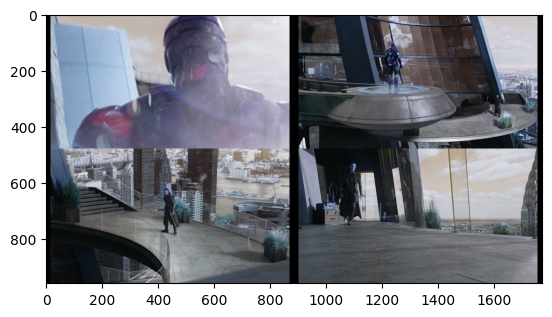

In [38]:
plt.imshow(frames[0])

In [39]:
#show_frames(frames, row_dim=1, num_of_images=None)

In [40]:
# Perform the detections
images_list, scores_detection_list = detect_objects_on_concatenate_images(images=frames,
                                                                prompts=["a black t-shirt"],
                                                                patch_size=24, 
                                                                window=10,      
                                                                stride=1)

  0%|          | 0/6 [00:00<?, ?it/s]

Shape of the patches = torch.Size([1, 40, 73, 3, 24, 24])



 17%|█▋        | 1/6 [01:24<07:03, 84.63s/it]

Shape of the patches = torch.Size([1, 40, 73, 3, 24, 24])



 33%|███▎      | 2/6 [02:33<05:00, 75.18s/it]

Shape of the patches = torch.Size([1, 40, 73, 3, 24, 24])



 50%|█████     | 3/6 [03:38<03:31, 70.66s/it]

Shape of the patches = torch.Size([1, 40, 73, 3, 24, 24])



 67%|██████▋   | 4/6 [04:44<02:17, 68.97s/it]

Shape of the patches = torch.Size([1, 40, 73, 3, 24, 24])



 83%|████████▎ | 5/6 [05:52<01:08, 68.31s/it]

Shape of the patches = torch.Size([1, 40, 73, 3, 24, 24])



100%|██████████| 6/6 [06:57<00:00, 69.52s/it]


In [41]:
# Divide the images and the scores
single_images, scores_list = divide_concatenated_images(images=images_list,
                                                        scores=scores_detection_list,
                                                        frame_size=frame_dimension,
                                                        fake_images_counter=fake_images_counter)

concat_x is 2, concat_y is 2


100%|██████████| 6/6 [00:00<00:00, 2038.71it/s]

The shape of the current image is (960, 1772, 3)
The shape of the current image is (960, 1772, 3)
The shape of the current image is (960, 1772, 3)
The shape of the current image is (960, 1772, 3)
The shape of the current image is (960, 1772, 3)
The shape of the current image is (960, 1772, 3)
The number of fake images is 3


In [42]:
print(f'The number of frame is {len(single_images)}')
assert len(single_images) == len(scores_list)

The number of frame is 21


In [43]:
# show_frames(single_images, row_dim=2, num_of_images=None)

In [44]:
# Get the bounding box
bounding_boxes_list = get_bounding_boxes(scores_list=scores_list,
                                         patch_size=18,
                                         threshold=0.2)

The shape of the detection is (20, 36)
Finished the computation of the bounding boxes
The number of boxes detected is 1
The number of cells different from zero is 367
The shape of the detection is (20, 36)
Finished the computation of the bounding boxes
The number of boxes detected is 2
The number of cells different from zero is 41
The shape of the detection is (20, 36)
Finished the computation of the bounding boxes
The number of boxes detected is 1
The number of cells different from zero is 56
The shape of the detection is (20, 36)
Finished the computation of the bounding boxes
The number of boxes detected is 2
The number of cells different from zero is 91
The shape of the detection is (20, 36)
Finished the computation of the bounding boxes
The number of boxes detected is 0
The number of cells different from zero is 0
The shape of the detection is (20, 36)
Finished the computation of the bounding boxes
The number of boxes detected is 1
The number of cells different from zero is 20
The 

100%|██████████| 21/21 [00:00<00:00, 149.82it/s]


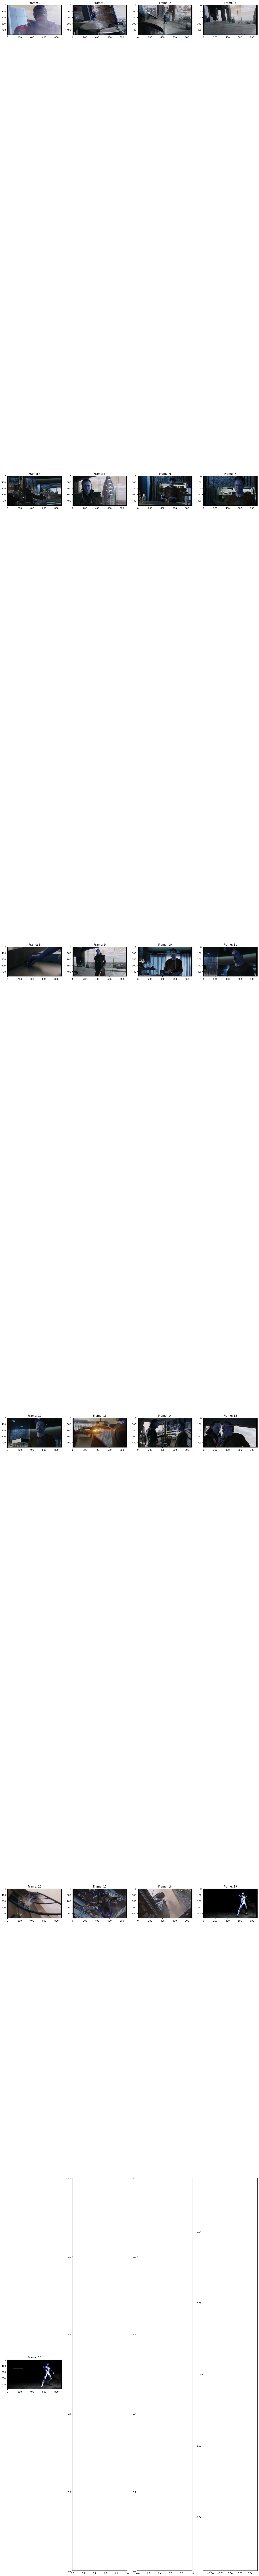

In [45]:
# Print the bounding boxes
show_frames_with_bounding_box(images_list=single_images,
                              bounding_boxes=bounding_boxes_list,
                              row_dim=4, 
                              num_of_images=None)

In [46]:
# Print the results
save_frames_with_bounding_box(images_list=single_images,
                              bounding_boxes=bounding_boxes_list)

100%|██████████| 21/21 [00:00<00:00, 34.73it/s]


## Extract the sub-images from the frames

In [47]:
info_dict = {}

# For each frame
for frame_number in tqdm(range(len(single_images))):
  # Instanciate the info_dict dictionary for the current frame
  info_dict[frame_number] = {}
  # For each bounding box associated to the current frame
  for bb_index in range(len(bounding_boxes_list[frame_number])):
    # Get the current bounding box
    bb = bounding_boxes_list[frame_number][bb_index]
    # Extract the object image from the frame
    bb_image = single_images[frame_number][bb[1]: bb[1]+bb[3], bb[0]: bb[0]+bb[2]] 
    # Define a name for the sub-image
    filename = r"image_" + str(frame_number) + "_" + str(bb_index) + ".png"
    # If save the sub-image if it is valid
    if bb_image.shape[0] > 0 and bb_image.shape[1] > 0:
      cv.imwrite(filename, bb_image)
      # Save the details into the dictionary
      info_dict[frame_number][bb_index] = {}
      info_dict[frame_number][bb_index]["Coordinates"] = bb
      info_dict[frame_number][bb_index]["Image"] = bb_image

100%|██████████| 21/21 [00:00<00:00, 435.69it/s]


In [48]:
# Check the number of bounding boxes saved for each frame
for frame_key, frame_item in info_dict.items():
    print(f'Frame {frame_key} has {len(frame_item.keys())}')

Frame 0 has 1
Frame 1 has 2
Frame 2 has 1
Frame 3 has 2
Frame 4 has 0
Frame 5 has 1
Frame 6 has 1
Frame 7 has 2
Frame 8 has 0
Frame 9 has 0
Frame 10 has 1
Frame 11 has 1
Frame 12 has 1
Frame 13 has 0
Frame 14 has 2
Frame 15 has 1
Frame 16 has 1
Frame 17 has 0
Frame 18 has 1
Frame 19 has 1
Frame 20 has 1


## Siamese Network comparisons

In [49]:
import tensorflow as tf

target_shape = (40,40)

In [50]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [51]:
# load the template and the detected images
template1 = preprocess_image("template1.jpg")
detected_images = []

for frame_key, frame_item in info_dict.items():
  for key, idx in info_dict[frame_key].items():
    image = tf.constant(info_dict[frame_key][key]['Image'], dtype='float32')/255.0
    detected_images.append(tf.image.resize(image, target_shape))

In [52]:
!unzip siamese_model90.zip

Archive:  siamese_model90.zip
   creating: siamese90/
   creating: siamese90/assets/
   creating: siamese90/variables/
  inflating: siamese90/variables/variables.data-00000-of-00001  
  inflating: siamese90/variables/variables.index  
 extracting: siamese90/fingerprint.pb  
  inflating: siamese90/keras_metadata.pb  
  inflating: siamese90/saved_model.pb  


In [53]:
# define the custom loss so that load_model funct works
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [58]:
# load the model 
siamese_network = tf.keras.models.load_model('/content/siamese90', custom_objects={'contrastive_loss': loss})

1/1 [==============================] - 1s 1s/step


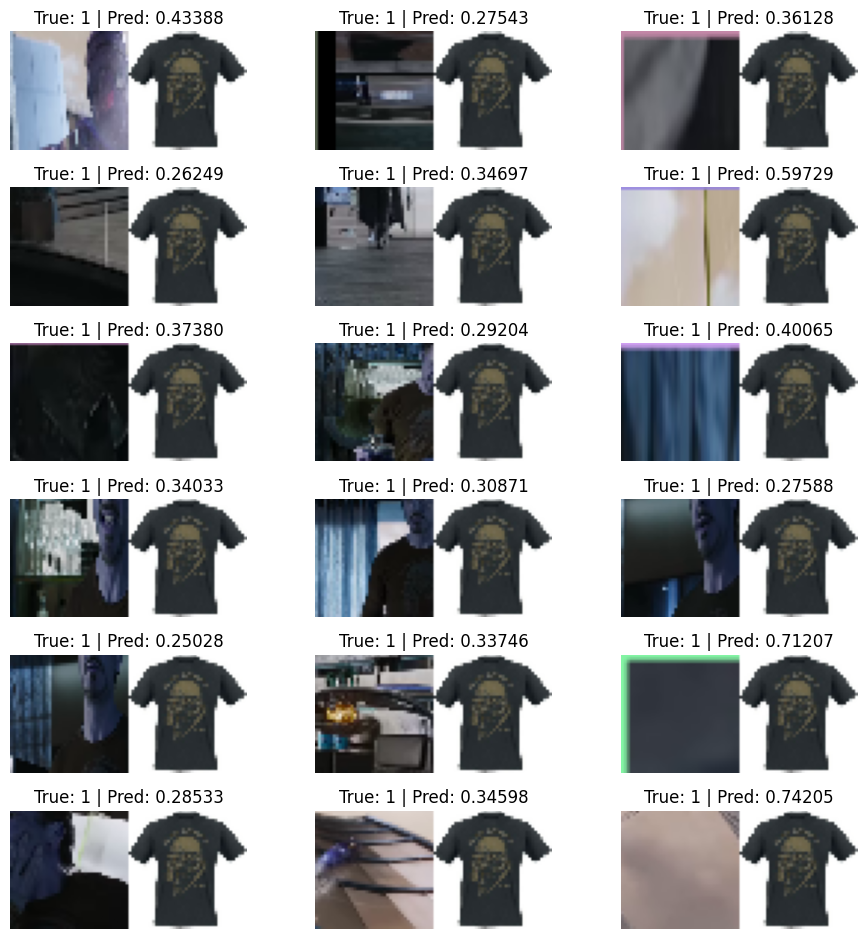

In [62]:
# predict similiraties using the siamese network
interest_pairs = np.array([[detected_images[i], template1] for i in range(20)])

pred = siamese_network.predict([interest_pairs[:, 0], interest_pairs[:, 1]])
visualize(interest_pairs, labels=[1 for i in range(20)], to_show=20, predictions=pred, test=True)